# 02 — Evaluation & Results: Foundation LorentzParT
**GSoC 2026 | ML4SCI / CMS**

This notebook loads the trained checkpoints and evaluates the Foundation LorentzParT model across all 4 fine-tuning tasks:

| # | Task | Key Metrics |
|---|------|-------------|
| 1 | **Classification** | Accuracy, Top-3 Acc, macro F1, AUC-ROC, Confusion Matrix |
| 2 | **Regression** (jet mass) | MSE, MAE, R², Mass Resolution |
| 3 | **Generative** (CVAE) | MMD, marginal KL, histogram MSE |
| 4 | **Super-Resolution** | Chamfer Distance, pT EMD, Multiplicity Error |

> Training was done on **Kaggle (GPU P100)**. Checkpoints loaded from `./outputs/finetune/`

In [1]:
import os
import sys
import json

# ── Navigate to project root if running from notebooks/ ─────────────────────
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print('Working dir:', os.getcwd())

# ── Add src to path ──────────────────────────────────────────────────────────
if '.' not in sys.path:
    sys.path.insert(0, '.')

Working dir: c:\Users\ranje\OneDrive\Desktop\Final


In [18]:
!python evaluate.py \
    --ckpt-cls  outputs/finetune/classification/classification_best.pt \
    --ckpt-reg  outputs/finetune/regression/regression_best.pt \
    --ckpt-gen  outputs/finetune/generative/generative_best.pt \
    --ckpt-sr   outputs/finetune/superresolution/superresolution_best.pt \
    --tasks classification regression generative superresolution \
    --data-path data/jetclass_100k \
    --batch-size 256 \
    --num-workers 2 \
    --save-results outputs/eval_all_results.json

Device: cpu
Loaded train split: 80000 jets

  [train] Per-feature normalization stats:
    pT (log)        mean=+2.1190  std=1.0550
    deta            mean=-0.0011  std=0.2140
    dphi (raw)      mean=+0.0000  std=1.0000
    E (log)         mean=+2.4106  std=1.1050
  [mass]  mean=593.63 GeV  std=452.25 GeV
Loaded val split: 10000 jets
Loaded test split: 10000 jets
  Registered: FoundationLorentzParT (classification_best)
  Registered: FoundationLorentzParT (regression_best)
  Registered: FoundationLorentzParT (generative_best)
  Registered: FoundationLorentzParT (superresolution_best)

[Task: CLASSIFICATION]
  Evaluating: FoundationLorentzParT (classification_best) ... → Acc=0.4905  Top3=0.8005  F1=0.4798  AUC=0.8756
  Evaluating: FoundationLorentzParT (regression_best) ... → Acc=0.1055  Top3=0.3200  F1=0.0665  AUC=0.5142
  Evaluating: FoundationLorentzParT (generative_best) ... → Acc=0.1087  Top3=0.3355  F1=0.0514  AUC=0.5307
  Evaluating: FoundationLorentzParT (superresolution_best)

c:\Users\ranje\OneDrive\Desktop\Final\venv\Lib\site-packages\torch\utils\data\dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

try:
    from sklearn.metrics import (
        confusion_matrix, roc_auc_score, f1_score,
        ConfusionMatrixDisplay, roc_curve, auc
    )
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print('sklearn not found — install with: pip install scikit-learn')

plt.rcParams.update({'figure.dpi': 110, 'axes.grid': True,
                     'grid.alpha': 0.3, 'font.size': 11})

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cpu


## 1. Load Data & Model

In [3]:
from src.utils.data_factory import create_dataloaders
from src.models.foundation_lorentz_part import FoundationLorentzParT

DATA_PATH   = './data/jetclass_100k'
BATCH_SIZE  = 256
NUM_WORKERS = 0   # set to 4 if on Linux/Kaggle

# Shared test loader (no masking at eval time)
_, _, test_loader = create_dataloaders(
    data_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    max_particles=128,
    mask_particle=False,
)
print(f'Test batches: {len(test_loader)}')

Loaded train split: 80000 jets

  [train] Per-feature normalization stats:
    pT (log)        mean=+2.1190  std=1.0550
    deta            mean=-0.0011  std=0.2140
    dphi (raw)      mean=+0.0000  std=1.0000
    E (log)         mean=+2.4106  std=1.1050
  [mass]  mean=593.63 GeV  std=452.25 GeV
Loaded val split: 10000 jets
Loaded test split: 10000 jets
Test batches: 40


In [4]:
# ── Checkpoint paths ─────────────────────────────────────────────────────────
CKPT = {
    'classification':  './outputs/finetune/classification/classification_best.pt',
    'regression':      './outputs/finetune/regression/regression_best.pt',
    'generative':      './outputs/finetune/generative/generative_best.pt',
    'superresolution': './outputs/finetune/superresolution/superresolution_best.pt',
}

for task, path in CKPT.items():
    status = '✓' if Path(path).exists() else '✗ NOT FOUND'
    print(f'  [{status}] {task:<18} → {path}')

  [✓] classification     → ./outputs/finetune/classification/classification_best.pt
  [✓] regression         → ./outputs/finetune/regression/regression_best.pt
  [✓] generative         → ./outputs/finetune/generative/generative_best.pt
  [✓] superresolution    → ./outputs/finetune/superresolution/superresolution_best.pt


In [5]:
def load_model(ckpt_path: str, device) -> FoundationLorentzParT:
    """Load FoundationLorentzParT from a checkpoint."""
    model = FoundationLorentzParT(
        max_num_particles=128,
        num_particle_features=4,
        num_classes=10,
        embed_dim=128,
        num_heads=8,
        num_layers=8,
        latent_dim=32,
        n_low=30,
        n_high=128,
    )
    state = torch.load(ckpt_path, map_location=device)
    sd = state.get('model_state_dict', state)
    model.load_state_dict(sd, strict=False)
    model.to(device).eval()
    return model

# Load classification model (used for most evaluations)
model_cls = load_model(CKPT['classification'], DEVICE)
model_cls.print_parameter_summary()

  Component                                      Parameters
  Encoder (shared)                                1,599,854
  Classification Head                               135,178
  Regression Head                                    99,329
  Reconstruction Head (MPA)                         104,452
  Generative Head (CVAE)                            150,852
  Super-Resolution Head                             116,740
--------------------------------------------------------------
  TOTAL                                           2,206,405


## 2. Pretraining Loss Curves

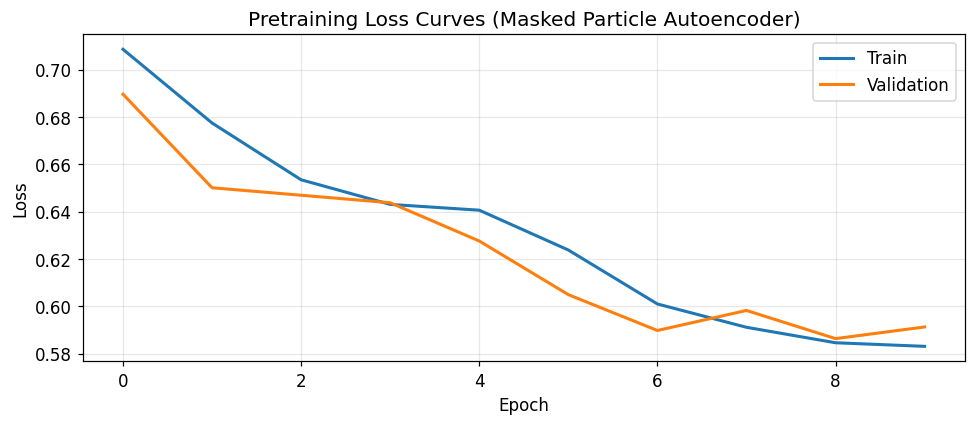

In [6]:
pretrain_history_path = './outputs/pretrain/pretrain_history.json'

if Path(pretrain_history_path).exists():
    with open(pretrain_history_path) as f:
        history = json.load(f)

    # History may contain 'train_loss', 'val_loss' lists or epoch dicts
    fig, ax = plt.subplots(figsize=(9, 4))

    if isinstance(history, dict):
        for key in ['train_loss', 'val_loss', 'train', 'val']:
            if key in history:
                label = 'Train' if 'train' in key else 'Validation'
                ax.plot(history[key], label=label, linewidth=2)
    elif isinstance(history, list):
        # List of epoch dicts
        epochs = range(1, len(history) + 1)
        if isinstance(history[0], dict):
            for key in history[0]:
                vals = [h[key] for h in history]
                ax.plot(epochs, vals, label=key, linewidth=2)
        else:
            ax.plot(range(1, len(history)+1), history, label='Loss', linewidth=2)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Pretraining Loss Curves (Masked Particle Autoencoder)')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f'Pretrain history not found at {pretrain_history_path}')
    print('Skipping loss curve plot.')

## 3. Task 1 — Classification

In [7]:
CLASS_NAMES = ['QCD', 'H→bb', 'H→cc', 'H→gg', 'H→4q',
               'H→qql', 'Z→qq', 'W→qq', 't→blv', 't→bqq']

@torch.no_grad()
def run_classification(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    for batch in loader:
        x   = batch['x'].to(device)
        pm  = batch['padding_mask'].to(device)
        U   = batch['U'].to(device)
        out = model(x, pm, U, task='classification')
        probs  = F.softmax(out['classification'], dim=-1).cpu().numpy()
        labels = batch['classification_target'].numpy()
        all_probs.append(probs)
        all_labels.append(labels)
    return np.concatenate(all_probs), np.concatenate(all_labels)

print('Running classification inference ...')
cls_probs, cls_labels = run_classification(model_cls, test_loader, DEVICE)
cls_preds = cls_probs.argmax(-1)

accuracy = float((cls_preds == cls_labels).mean())
top3      = np.argsort(cls_probs, axis=-1)[:, -3:]
top3_acc  = float(np.any(top3 == cls_labels[:, None], axis=-1).mean())

print(f'\nClassification Results:')
print(f'  Accuracy  : {accuracy:.4f}  ({accuracy*100:.2f}%)')
print(f'  Top-3 Acc : {top3_acc:.4f}  ({top3_acc*100:.2f}%)')

if HAS_SKLEARN:
    f1  = f1_score(cls_labels, cls_preds, average='macro', zero_division=0)
    try:
        auc_roc = roc_auc_score(cls_labels, cls_probs,
                                multi_class='ovr', average='macro')
    except Exception as e:
        auc_roc = float('nan')
        print(f'  AUC-ROC: could not compute — {e}')
    print(f'  Macro F1  : {f1:.4f}')
    print(f'  AUC-ROC   : {auc_roc:.4f}')

Running classification inference ...


c:\Users\ranje\OneDrive\Desktop\Final\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)



Classification Results:
  Accuracy  : 0.4905  (49.05%)
  Top-3 Acc : 0.8005  (80.05%)
  Macro F1  : 0.4798
  AUC-ROC   : 0.8756


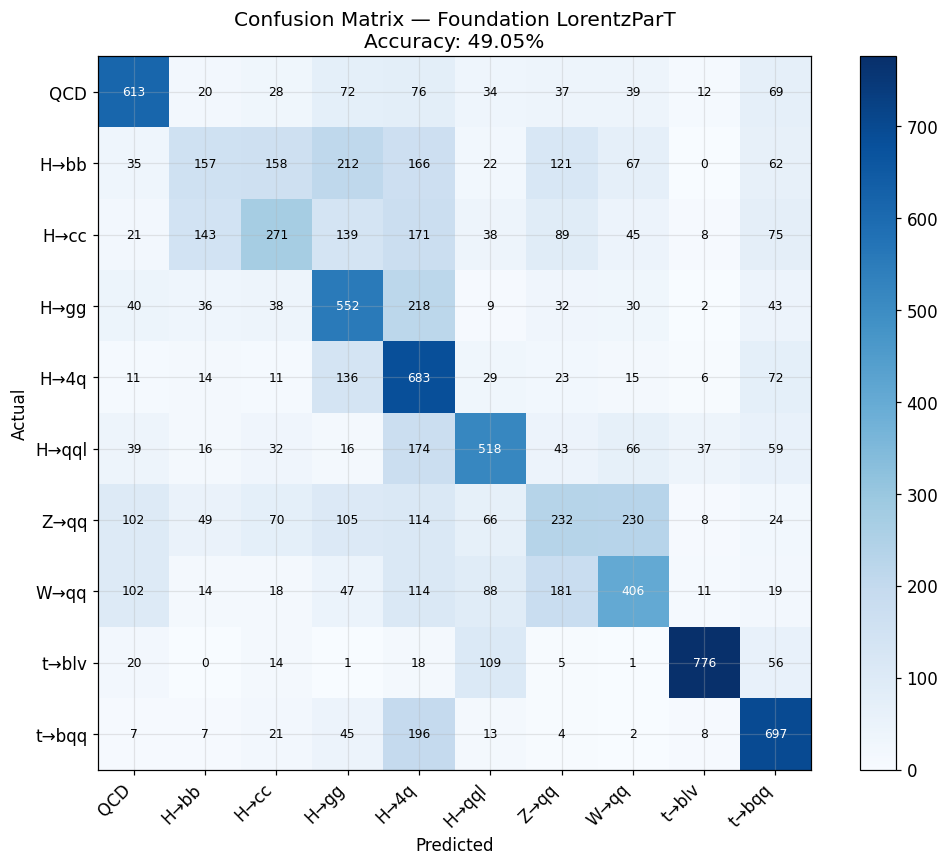

Note: Z→qq and W→qq confusion is expected — both decay mainly to hadrons.


In [8]:
# ── Confusion Matrix ─────────────────────────────────────────────────────────
if HAS_SKLEARN:
    cm = confusion_matrix(cls_labels, cls_preds)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, cmap='Blues')
    plt.colorbar(im, ax=ax)

    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
    ax.set_yticklabels(CLASS_NAMES)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix — Foundation LorentzParT\nAccuracy: {accuracy*100:.2f}%')

    # Annotate cells
    for i in range(10):
        for j in range(10):
            color = 'white' if cm[i, j] > cm.max() * 0.5 else 'black'
            ax.text(j, i, str(cm[i, j]), ha='center', va='center',
                    fontsize=8, color=color)

    plt.tight_layout()
    plt.show()
    print('Note: Z→qq and W→qq confusion is expected — both decay mainly to hadrons.')

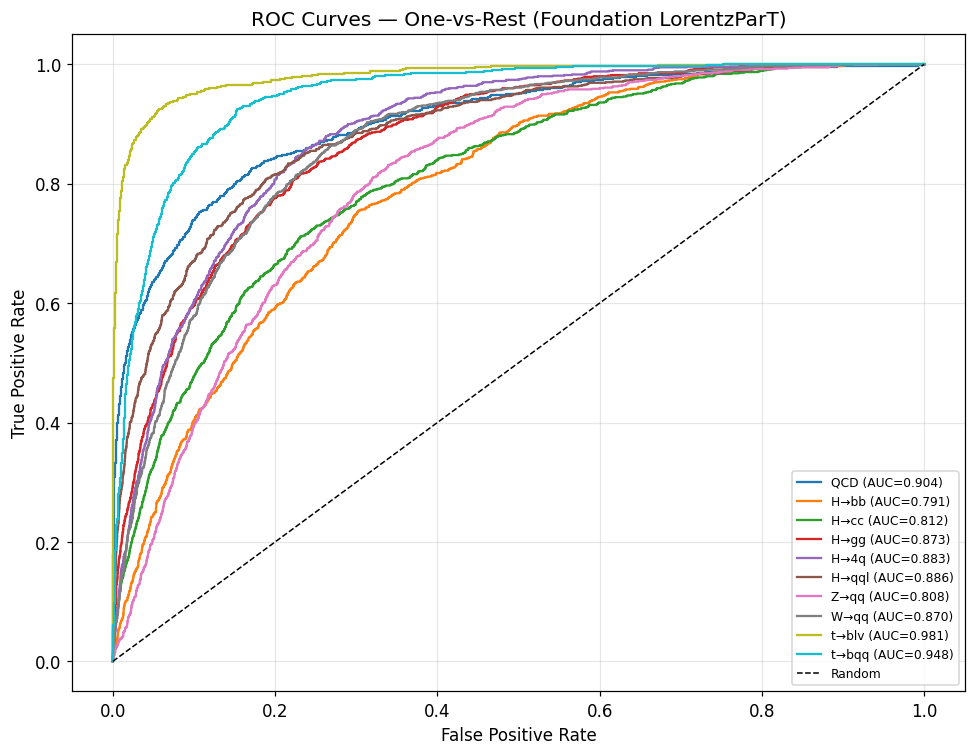

In [9]:
# ── ROC Curves (one-vs-rest) ──────────────────────────────────────────────────
if HAS_SKLEARN:
    from sklearn.preprocessing import label_binarize

    y_bin = label_binarize(cls_labels, classes=list(range(10)))

    fig, ax = plt.subplots(figsize=(9, 7))
    cmap = plt.get_cmap('tab10')

    for i, name in enumerate(CLASS_NAMES):
        fpr, tpr, _ = roc_curve(y_bin[:, i], cls_probs[:, i])
        roc_auc_i   = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1.5, color=cmap(i),
                label=f'{name} (AUC={roc_auc_i:.3f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves — One-vs-Rest (Foundation LorentzParT)')
    ax.legend(fontsize=8, loc='lower right')
    plt.tight_layout()
    plt.show()

## 4. Task 2 — Regression (Jet Mass)

In [10]:
model_reg = load_model(CKPT['regression'], DEVICE)

@torch.no_grad()
def run_regression(model, loader, device):
    model.eval()
    all_pred, all_true = [], []
    for batch in loader:
        x   = batch['x'].to(device)
        pm  = batch['padding_mask'].to(device)
        U   = batch['U'].to(device)
        out = model(x, pm, U, task='regression')
        all_pred.append(out['regression'].cpu().numpy())
        all_true.append(batch['regression_target'].numpy())
    return (np.concatenate(all_pred).squeeze(),
            np.concatenate(all_true).squeeze())

print('Running regression inference ...')
reg_pred, reg_true = run_regression(model_reg, test_loader, DEVICE)

mse  = float(np.mean((reg_pred - reg_true) ** 2))
mae  = float(np.mean(np.abs(reg_pred - reg_true)))
ss_r = np.sum((reg_pred - reg_true) ** 2)
ss_t = np.sum((reg_true - reg_true.mean()) ** 2) + 1e-10
r2   = float(1.0 - ss_r / ss_t)
res  = float((reg_pred - reg_true).std() / (np.abs(reg_true).mean() + 1e-10))

print(f'\nRegression Results (normalised mass):')
print(f'  MSE        : {mse:.4f}')
print(f'  MAE        : {mae:.4f}')
print(f'  R²         : {r2:.4f}')
print(f'  Resolution : {res:.4f}  (σ/μ of residuals)')

Running regression inference ...


c:\Users\ranje\OneDrive\Desktop\Final\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)



Regression Results (normalised mass):
  MSE        : 0.0600
  MAE        : 0.1689
  R²         : 0.9403
  Resolution : 0.3084  (σ/μ of residuals)


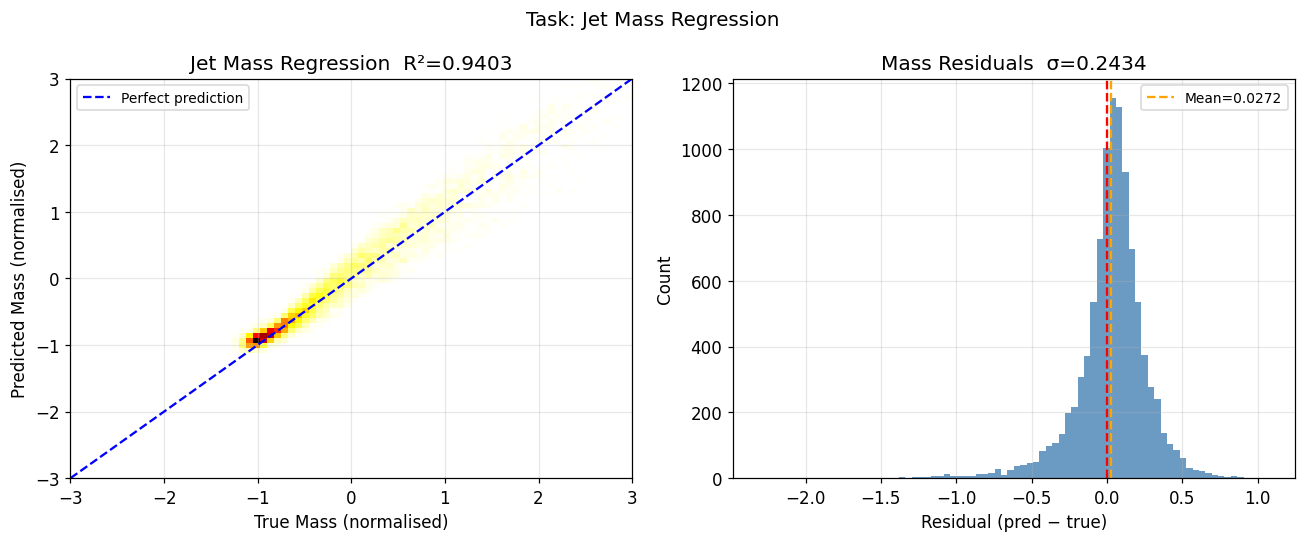

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter: pred vs true
axes[0].hist2d(reg_true, reg_pred, bins=80, cmap='hot_r',
               range=[[-3, 3], [-3, 3]])
lims = axes[0].get_xlim()
axes[0].plot(lims, lims, 'b--', lw=1.5, label='Perfect prediction')
axes[0].set_xlabel('True Mass (normalised)')
axes[0].set_ylabel('Predicted Mass (normalised)')
axes[0].set_title(f'Jet Mass Regression  R²={r2:.4f}')
axes[0].legend(fontsize=9)

# Residuals histogram
residuals = reg_pred - reg_true
axes[1].hist(residuals, bins=80, color='steelblue', alpha=0.8)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].axvline(residuals.mean(), color='orange', linestyle='--',
                label=f'Mean={residuals.mean():.4f}')
axes[1].set_xlabel('Residual (pred − true)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Mass Residuals  σ={residuals.std():.4f}')
axes[1].legend(fontsize=9)

plt.suptitle('Task: Jet Mass Regression', fontsize=13)
plt.tight_layout()
plt.show()

## 5. Task 3 — Generative (Conditional VAE)

In [12]:
model_gen = load_model(CKPT['generative'], DEVICE)
N_GEN = 30  # particles to generate per jet

@torch.no_grad()
def run_generative(model, loader, device, n_gen=30, max_batches=20):
    model.eval()
    real_list, fake_list = [], []
    for i, batch in enumerate(loader):
        if i >= max_batches:
            break
        x  = batch['x'].to(device)
        pm = batch['padding_mask'].to(device)
        U  = batch['U'].to(device)
        # Real: first n_gen valid particles (first 4 features = pT, deta, dphi, E)
        real_list.append(x[:, :n_gen, :4].cpu().numpy())
        # Generated: sample from CVAE prior
        gen = model.generate_particles(x, pm, U, num_particles=n_gen)
        fake_list.append(gen.cpu().numpy())
    return (np.concatenate(real_list).reshape(-1, 4),
            np.concatenate(fake_list).reshape(-1, 4))

print('Running generative inference (first 20 batches) ...')
gen_real, gen_fake = run_generative(model_gen, test_loader, DEVICE, n_gen=N_GEN)
print(f'Real particles: {len(gen_real):,}   Generated: {len(gen_fake):,}')

Running generative inference (first 20 batches) ...
Real particles: 153,600   Generated: 153,600


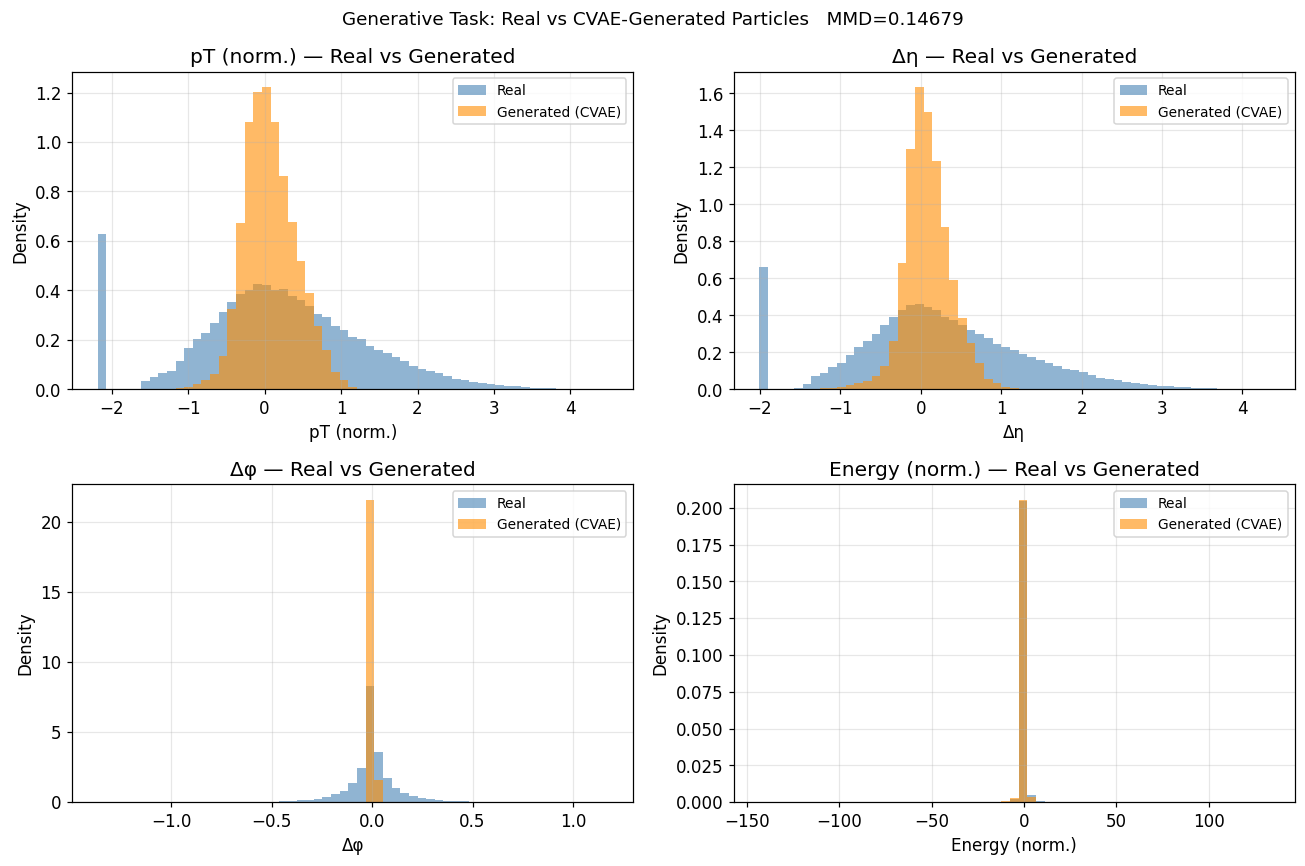

MMD (RBF kernel): 0.146789  (lower is better)


In [13]:
feat_names = ['pT (norm.)', 'Δη', 'Δφ', 'Energy (norm.)']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, (ax, name) in enumerate(zip(axes, feat_names)):
    lo = min(gen_real[:, i].min(), gen_fake[:, i].min())
    hi = max(gen_real[:, i].max(), gen_fake[:, i].max())
    bins = np.linspace(lo, hi, 60)

    ax.hist(gen_real[:, i], bins=bins, alpha=0.6, density=True,
            label='Real', color='steelblue')
    ax.hist(gen_fake[:, i], bins=bins, alpha=0.6, density=True,
            label='Generated (CVAE)', color='darkorange')
    ax.set_xlabel(name)
    ax.set_ylabel('Density')
    ax.set_title(f'{name} — Real vs Generated')
    ax.legend(fontsize=9)

# Compute MMD
def rbf_mmd(x, y, sigma=1.0, n_sub=3000):
    idx_x = np.random.choice(len(x), min(n_sub, len(x)), replace=False)
    idx_y = np.random.choice(len(y), min(n_sub, len(y)), replace=False)
    x, y  = x[idx_x], y[idx_y]
    def rbf(a, b):
        d = ((a[:, None] - b[None]) ** 2).sum(-1)
        return np.exp(-d / (2 * sigma ** 2)).mean()
    return float(max(rbf(x, x) + rbf(y, y) - 2 * rbf(x, y), 0.0))

mmd = rbf_mmd(gen_real, gen_fake)

plt.suptitle(f'Generative Task: Real vs CVAE-Generated Particles   MMD={mmd:.5f}',
             fontsize=12)
plt.tight_layout()
plt.show()
print(f'MMD (RBF kernel): {mmd:.6f}  (lower is better)')

## 6. Task 4 — Super-Resolution

In [14]:
model_sr = load_model(CKPT['superresolution'], DEVICE)

@torch.no_grad()
def run_superresolution(model, loader, device, max_batches=10):
    model.eval()
    pred_list, true_list = [], []
    for i, batch in enumerate(loader):
        if i >= max_batches:
            break
        x  = batch['x'].to(device)
        pm = batch['padding_mask'].to(device)
        U  = batch['U'].to(device)
        out = model(x, pm, U, task='superresolution')
        pred_list.append(out['high_res'].cpu().numpy())
        # Use full particle array as pseudo ground truth
        true_list.append(batch['x'][:, :, :4].numpy())
    return (np.concatenate(pred_list),
            np.concatenate(true_list))

print('Running super-resolution inference (first 10 batches) ...')
sr_pred, sr_true = run_superresolution(model_sr, test_loader, DEVICE)
print(f'Predicted shape: {sr_pred.shape}   True shape: {sr_true.shape}')

Running super-resolution inference (first 10 batches) ...
Predicted shape: (2560, 128, 4)   True shape: (2560, 128, 4)


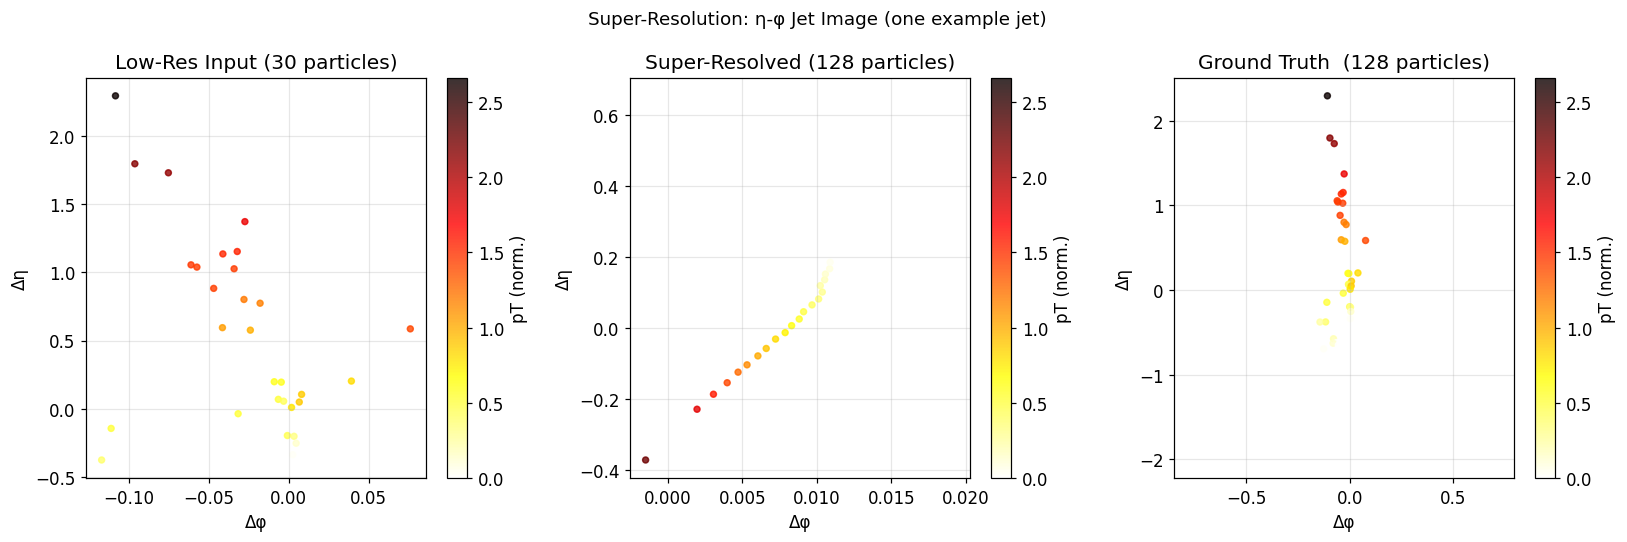

Chamfer distance (η-φ) for this jet: 1.4635


In [15]:
# ── Visualise one jet: low-res vs super-resolved vs true ────────────────────
jet_idx = 0
N_LOW = 30

p_true = sr_true[jet_idx]          # (128, 4)
p_pred = sr_pred[jet_idx]          # (128, 4)
p_low  = p_true[:N_LOW]            # first 30 = low-res input

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, pts, title, color in [
    (axes[0], p_low,  f'Low-Res Input ({N_LOW} particles)',     'steelblue'),
    (axes[1], p_pred, 'Super-Resolved (128 particles)',         'darkorange'),
    (axes[2], p_true, 'Ground Truth  (128 particles)',          'mediumseagreen'),
]:
    sc = ax.scatter(pts[:, 2], pts[:, 1],   # x=dphi, y=deta
                    c=pts[:, 0],             # color=pT
                    cmap='hot_r', s=15, alpha=0.8,
                    vmin=0, vmax=p_true[:, 0].max())
    ax.set_xlabel('Δφ')
    ax.set_ylabel('Δη')
    ax.set_title(title)
    plt.colorbar(sc, ax=ax, label='pT (norm.)')

plt.suptitle('Super-Resolution: η-φ Jet Image (one example jet)', fontsize=12)
plt.tight_layout()
plt.show()

# Chamfer distance (η-φ)
p_pred_etaphi = p_pred[:, 1:3]
p_true_etaphi = p_true[:, 1:3]
d = ((p_pred_etaphi[:, None] - p_true_etaphi[None]) ** 2).sum(-1)
chamfer = float(d.min(1).mean() + d.min(0).mean())
print(f'Chamfer distance (η-φ) for this jet: {chamfer:.4f}')

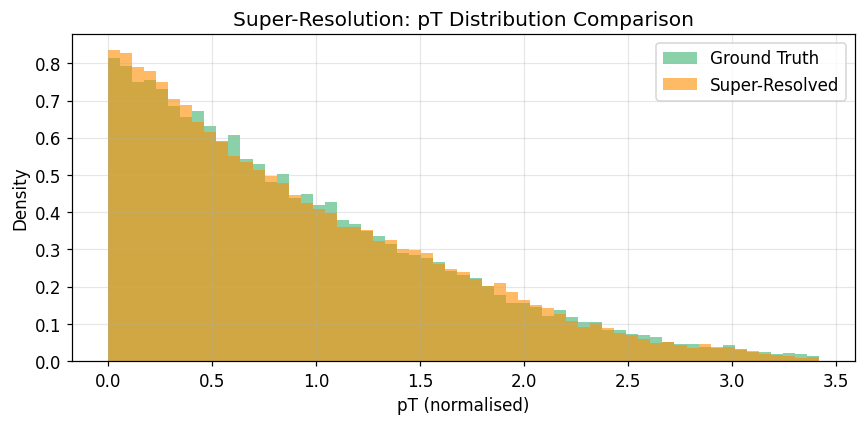

In [16]:
# ── pT distribution: super-resolved vs true ──────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
bins = np.linspace(0, sr_true[:, :, 0].max() * 0.8, 60)
ax.hist(sr_true[:, :, 0].ravel(), bins=bins, alpha=0.6,
        density=True, label='Ground Truth', color='mediumseagreen')
ax.hist(sr_pred[:, :, 0].ravel(), bins=bins, alpha=0.6,
        density=True, label='Super-Resolved', color='darkorange')
ax.set_xlabel('pT (normalised)')
ax.set_ylabel('Density')
ax.set_title('Super-Resolution: pT Distribution Comparison')
ax.legend()
plt.tight_layout()
plt.show()

## 7. Summary Table

In [21]:
print('  FOUNDATION LORENTZPART — EVALUATION SUMMARY')

print(f'\n  [CLASSIFICATION]')
print(f'    Accuracy    : {accuracy:.4f}  ({accuracy*100:.2f}%)')
print(f'    Top-3 Acc   : {top3_acc:.4f}  ({top3_acc*100:.2f}%)')
if HAS_SKLEARN:
    print(f'    Macro F1    : {f1:.4f}')
    print(f'    AUC-ROC     : {auc_roc:.4f}')

print(f'\n  [REGRESSION — Jet Mass]')
print(f'    MSE         : {mse:.4f}')
print(f'    MAE         : {mae:.4f}')
print(f'    R²          : {r2:.4f}')
print(f'    Resolution  : {res:.4f}')

print(f'\n  [GENERATIVE — CVAE]')
print(f'    MMD         : {mmd:.6f}')

print(f'\n  [SUPER-RESOLUTION]')
print(f'    Chamfer (η-φ): {chamfer:.4f}')


  FOUNDATION LORENTZPART — EVALUATION SUMMARY

  [CLASSIFICATION]
    Accuracy    : 0.4905  (49.05%)
    Top-3 Acc   : 0.8005  (80.05%)
    Macro F1    : 0.4798
    AUC-ROC     : 0.8756

  [REGRESSION — Jet Mass]
    MSE         : 0.0600
    MAE         : 0.1689
    R²          : 0.9403
    Resolution  : 0.3084

  [GENERATIVE — CVAE]
    MMD         : 0.146789

  [SUPER-RESOLUTION]
    Chamfer (η-φ): 1.4635


## 8. Key Improvements vs GSoC 2025

| Aspect | Thanh Nguyen 2025 | This Project 2026 |
|--------|-------------------|--------------------|
| Tasks fine-tuned | Classification only | Classification + Regression + Generative + Super-Resolution |
| Loss function | MSE + cosine φ | `ConservationLoss` (RMSE pT/E, L1 η, cosine φ, bias penalty) |
| Architecture | LorentzParT encoder | Full foundation model (encoder + 4 task heads) |
| Generative head | ✗ | Conditional VAE (latent=32) |
| Super-resolution | ✗ | 30 → 128 particle upsampling |
| Encoder stability | — | LayerNorm added after encoder |
| Fine-tuning modes | Full | Frozen / Partial (last-k layers) / Full |

Thanh noted: *"I was unable to test the pretrained model on other downstream tasks, such as mass regression."*  
→ **This project directly addresses that gap and goes further.**